# **Importing necessary libraries and modules**

In [119]:
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas import read_csv
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Lambda, Bidirectional, BatchNormalization
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping
from sklearn.model_selection import train_test_split
from google.colab import drive
from keras import regularizers
from keras.optimizers import SGD, Adagrad, Adadelta, Nadam
from keras import backend as K
from keras.regularizers import Regularizer
from keras.utils import register_keras_serializable

**Connecting to the drive to acces the data**

In [120]:
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


**Loading the datasets stored in the drive**

The data was preprocessed and stored on the drive for easier accesibility


*   preprocessed_train_data is the data collected for the iperf ran for the duration of 10,20,30,40 Seconds
*   preprocessed_val_data is the data collected for the iperf ran for the duration of 50 Seconds.
*   preprocessed_test_data is the data collected for the iperf ran for the duration of 60 Seconds.
*   preprocessed_train_val_data is a combination of both train and validation sets



In [121]:

# Using 3 datasets overall:
# train, validation, and testing

DATAPATH = '/content/gdrive/My Drive/Data/'
TRAINDATAFILE = DATAPATH+'preprocessed_train_data.csv'
VALDATAFILE = DATAPATH+'preprocessed_val_data.csv'

TRAINVALDATAFILE = DATAPATH+'preprocessed_train_val_data.csv'
TESTDATAFILE = DATAPATH+'preprocessed_test_data.csv'

train_dataset = read_csv(TRAINDATAFILE, header=0, index_col=0)
val_dataset = read_csv(VALDATAFILE, header=0, index_col=0)

train_all_dataset = read_csv(TRAINVALDATAFILE, header=0, index_col=0)
test_dataset = read_csv(TESTDATAFILE, header=0, index_col=0)

print(train_dataset.shape)
print(val_dataset.shape)
print(train_all_dataset.shape)
print(test_dataset.shape)

(1584, 6)
(392, 6)
(1976, 6)
(391, 6)


**Having an overview of the first rows of the data**

In [122]:
train_all_dataset.head()

,Bandwidth (Mbits/sec),Duration,Duration_of_measurement,Interval_stage,Tranfered Trafic (KBytes),Direction_Coded
0,12.60,10,0.25,1,0.750000,1
1,12.60,10,0.25,2,0.750977,0
2,10.50,10,0.75,3,0.625000,1
3,8.39,10,0.75,4,0.500000,0
4,10.50,10,1.25,5,0.625000,1


**A little more preprocessong of the datasets.**

In [123]:
# Concatenating the train and test datasets to create a single dataset
dataset = pd.concat([train_all_dataset, test_dataset], axis=0)
print(dataset.shape)

(2367, 6)


In [124]:
# Droping off irrelevant columns
df = train_all_dataset.drop(['Duration_of_measurement'], axis=1)
df.head()

,Bandwidth (Mbits/sec),Duration,Interval_stage,Tranfered Trafic (KBytes),Direction_Coded
0,12.60,10,1,0.750000,1
1,12.60,10,2,0.750977,0
2,10.50,10,3,0.625000,1
3,8.39,10,4,0.500000,0
4,10.50,10,5,0.625000,1


In [125]:
# I rename columns in the dataset to improve readability and clarity.
# Column 'Tranfered Trafic (KBytes)' is being rectified for a spelling error.
# Column 'Duration' is renamed to 'Duration(Sec)' to explicitly state that the duration is measured in seconds.
# Column 'Direction_Coded' is being renamed to 'Direction (up-link /down-link)' to provide indication of the data it shows.
dataset.rename(columns={'Tranfered Trafic (KBytes)': 'Transfered Trafic (KBytes)','Duration': 'Duration(Sec)', 'Direction_Coded':'Direction (up-link /down-link)'}, inplace=True)

In [126]:
# Confirming the position of target feature (Transfered Trafic (KBytes))
column_name = 'Transfered Trafic (KBytes)'
column_index = dataset.columns.get_loc(column_name)

print("Index of column '{}' is: {}".format(column_name, column_index))

Index of column 'Transfered Trafic (KBytes)' is: 4




**Function to prepare input-output pairs for trainning the LSTM (our time series prediction model)**

In [127]:
def prepare_dataset(data, lookback, future_interval):
    X, y = [], []
    for i in range(len(data) - lookback - future_interval + 1):
        # Extracting input sequence with number of rows = (lookback) and all the columns
        input_seq = data[i:(i + lookback), :]

        # Extracting output for the future interval
        output = data[i + lookback + future_interval - 1, 4]  # column 4 is the one of Transfered_data

        X.append(input_seq)
        y.append(output)

    return np.array(X), np.array(y)

# Defining lookback and future interval
data = dataset.values
lookback = 3  # Number of time steps to look back
future_interval = 1  # Future interval for prediction (e.g., if its , 3 the model will predict 3 times steps ahead)

# Preparing input-output pairs for training
X_train_full, y_train_full = prepare_dataset(data, lookback, future_interval)

**Using the train_test_split function to split the data into training and test while preserving the temporal order of the data (shuffle=False), which is crucial for time series prediction tasks.**

**Steps performed in sliting:**
*   I perform 2 splits.
*   First I split the entire dataset into Training and testing, where the last bit (20%) of the data is reserved for testing (this is the data containing majority of the transmissions performed for 60 Seconds).
*   Secondly I split the training set into 2 (Training and validation (20%)), where the validation set is the data contaioning majority of the transmissios performed for 50 seconds.



In [128]:
# The last bit 20% is split off for testing & evaluation
X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(X_train_full, y_train_full, test_size=0.2, shuffle=False)

In [129]:
# Splitting off a validation set 20% to be used in training
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, shuffle=False)

In [130]:
# Reshaping the training and testing input data into a 2D array required for ML models
X_train_reshaped = X_train.reshape(X_train.shape[0], -1)
X_test_reshaped = X_test_full.reshape(X_test_full.shape[0], -1)
X_val_reshaped = X_val.reshape(X_val.shape[0], -1)


**Applying MinMaxScaler from sklearn.preprocessing. Normalizing the data to ensures that all features have the same scale, which can help the model to converge faster and perform better.
I reshape the data it back to a 3D array to be used as input for an LSTM model.**

In [131]:
# Initializing and fit MinMaxScaler
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train_reshaped)
X_val_scaled = scaler.transform(X_val_reshaped)
X_test_scaled = scaler.transform(X_test_reshaped)

# Reshaping back to 3D for LSTM input
X_train_scaled = X_train_scaled.reshape(X_train.shape)
X_val_scaled = X_val_scaled.reshape(X_val.shape)
X_test_scaled = X_test_scaled.reshape(X_test_full.shape)

**Defining and fitting the model**

In [132]:
class ElasticNetRegularizer(Regularizer):
    def __init__(self, l1=0.0, l2=0.0):
        self.l1 = l1
        self.l2 = l2

    def __call__(self, x):
        return self.l1 * tf.reduce_sum(tf.abs(x)) + self.l2 * tf.reduce_sum(tf.square(x))

    def get_config(self):
        return {'l1': self.l1, 'l2': self.l2}

# Registering ElasticNetRegularizer with Keras
register_keras_serializable()(ElasticNetRegularizer)

# Rescaling the training set for LSTM input
X_train_reshaped = X_train_scaled.reshape(X_train_scaled.shape[0], X_train_scaled.shape[1], X_train_scaled.shape[2])
X_val_reshaped = X_val.reshape(X_val.shape[0], X_val.shape[1], X_val.shape[2])

model = Sequential()
model.add(Bidirectional(LSTM(256, return_sequences=True, kernel_regularizer=ElasticNetRegularizer(l1=0.001, l2=0.01)), input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2])))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(256, return_sequences=True, kernel_regularizer=ElasticNetRegularizer(l1=0.001, l2=0.01))))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(128, return_sequences=False, kernel_regularizer=ElasticNetRegularizer(l1=0.001, l2=0.01))))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu', kernel_regularizer=ElasticNetRegularizer(l1=0.001, l2=0.01)))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(1))

model.compile(optimizer=Nadam(lr=0.000001), loss='mae')
history = model.fit(X_train_reshaped, y_train, epochs=40, batch_size=64, validation_data=(X_val_scaled, y_val))


Epoch 1/40
24/24 [==============================] - 16s 106ms/step - loss: 72.6759 - val_loss: 62.9667
Epoch 2/40
24/24 [==============================] - 0s 19ms/step - loss: 52.6395 - val_loss: 44.3740
Epoch 3/40
24/24 [==============================] - 0s 19ms/step - loss: 36.5228 - val_loss: 31.1448
Epoch 4/40
24/24 [==============================] - 0s 19ms/step - loss: 25.7124 - val_loss: 22.6553
Epoch 5/40
24/24 [==============================] - 0s 20ms/step - loss: 18.8113 - val_loss: 17.1964
Epoch 6/40
24/24 [==============================] - 0s 19ms/step - loss: 14.2872 - val_loss: 13.5325
Epoch 7/40
24/24 [==============================] - 0s 19ms/step - loss: 11.1310 - val_loss: 10.8035
Epoch 8/40
24/24 [==============================] - 0s 19ms/step - loss: 8.7551 - val_loss: 8.6887
Epoch 9/40
24/24 [==============================] - 1s 21ms/step - loss: 6.9678 - val_loss: 7.1760
Epoch 10/40
24/24 [==============================] - 1s 24ms/step - loss: 5.5949 - val_loss: 

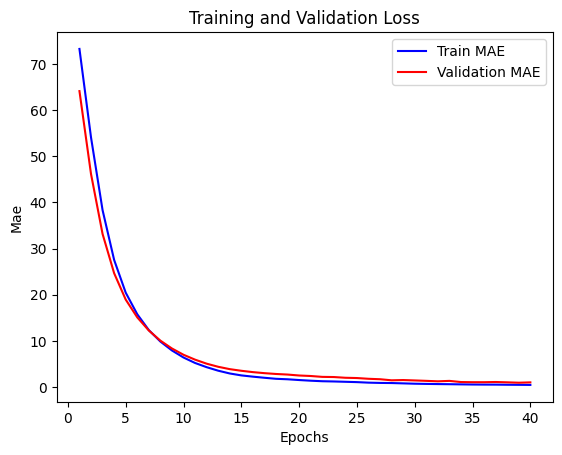

In [116]:
# Getting the training and validation loss from the history
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plotting the training and validation loss
epochs = range(1, len(train_loss) + 1)
plt.plot(epochs, train_loss, 'b', label='Train MAE')
plt.plot(epochs, val_loss, 'r', label='Validation MAE')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Mae')
plt.legend()
plt.show()

**Evaluating the model on the test set and make predictions (the test set contains data collected for the time interval of 60Seconds)**

In [133]:
# Evaluating the model on the test set
loss = model.evaluate(X_test_scaled, y_test_full)

# Making predictions on the test set
y_pred = model.predict(X_test_scaled)

15/15 [==============================] - 2s 5ms/step


**Visualizing the curves to see the relationship between the prediction and the actual**

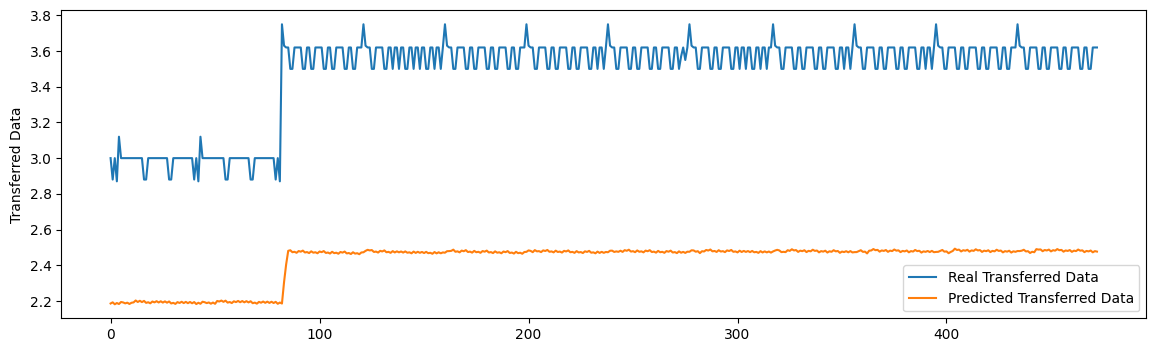

In [134]:
# Ploting the real and predicted transferred data for evalution of the model
plt.figure(figsize=(14, 4))
plt.plot(y_test_full, label='Real Transferred Data')
plt.plot(y_pred, label='Predicted Transferred Data')
plt.ylabel('Transferred Data')
plt.legend()
plt.show()